In [251]:
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
# import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
import copy
import statsmodels.api as sm
from patsy import dmatrices
import random
random.seed(123)


Populating the interactive namespace from numpy and matplotlib


In [254]:
happy = pd.read_excel('Happy_Score_Data.xlsx', 0)
region = pd.read_excel('Happy_Score_Data.xlsx', 4)
foreign = pd.read_excel('Happy_Score_Data.xlsx', 3)

df = happy.merge(region[['country','Region indicator']],
                  how='left',
                 left_on = 'country',
                 right_on='country')
df = df.drop(df.columns[12:18], axis=1) #dropped these: Democratic Quality, Delivery Quality, Standard deviation of ladder by country-year	Standard deviation/Mean of ladder by country-year	GINI index (World Bank estimate)	GINI index (World Bank estimate), average 2000-15	gini of household income reported in Gallup, by wp5-year

df.columns = ['country', 'year', 'happy_score', 'GDP', 'support', 'life_exp', 'freedom', 'generosity','corruption','positive','negative','conf_govt', 'income','region']
df_y = df['happy_score'] #series of the output variable
#df

### EDA of North America/Australia/New Zealand Points

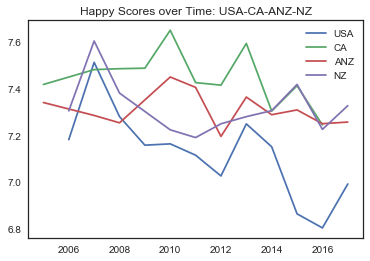

In [253]:
#######################################################################################################@####################
#We want to see the happiness scores of USA over time as well as the other countries it is categorized with by region
# USA is grouped with: Canada, New Zealand, and Australia
#######################################################################################################@####################
df.groupby(['region'])['country'].count()
df_na_anz = df[df['region'] == 'North America and ANZ']
df_usa = df[df['country'] == "United States"]
df_na = df[df['country'].isin(['United States', 'Canada'])]
df_anz  = df[df['country'] == "Australia"]
df_ca = df[df['country'] == "Canada"]
df_nz = df[df['country'] == "New Zealand"]


plot(df_usa['year'], df_usa['happy_score'], marker='None', linestyle='-', label='USA')
plot(df_ca['year'], df_ca['happy_score'], marker='None', linestyle='-', label='CA')
plot(df_anz['year'], df_anz['happy_score'], marker='None', linestyle='-', label='ANZ')
plot(df_nz['year'], df_nz['happy_score'], marker='None', linestyle='-', label='NZ')
title('Happy Scores over Time: USA-CA-ANZ-NZ')
legend(loc='best')

#######################################################################################################@####################
#this graph shows us how over the past 10-ish years, USA's happiness scores have gone down. But why?
#What is causing the happiness to go down? That is what we will find out.
############################################################################################################################

# Countries in 2017

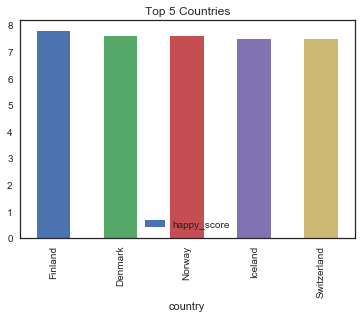

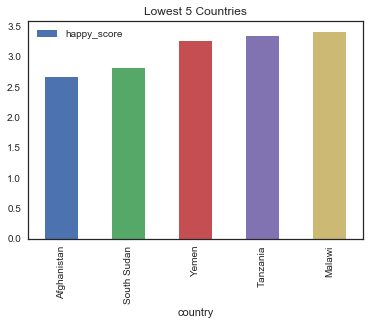

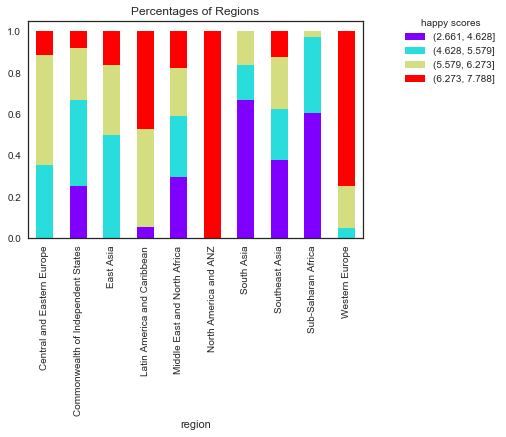

In [255]:
#######################################################################################################@####################
# More EDA: we will look at the happiness scores of all the countries and regions in 2017 because it is the most recent
# happiness score available.
#######################################################################################################@####################
df_17 = df[df['year'] == 2017]

#######################################################################################################@####################
#This shows the top 5 happy countries of 2017
#######################################################################################################@####################
top_17 = ((df_17.sort_values('happy_score', ascending = False)).head(5))

top_17.plot('country', 'happy_score', kind="bar", title='Top 5 Countries') #top 5 countries of happy scores


#######################################################################################################@####################
#This shows the lowest 5 happy countries of 2017
#######################################################################################################@####################
low_17 = ((df_17.sort_values('happy_score')).head(5))
low_17.plot('country', 'happy_score', kind="bar", title='Lowest 5 Countries') #lowest 5 happy score countries

#######################################################################################################@####################
# this plot shows each region and the percentages of happiness scores in each region
# for example: Western Europe: 5% countries in Western Europe have scores between 4.6-5.6
# 20% of the countries in Western Europe have scores between 5.6-6.3
# 75% of the countries in Western Europe have scores between 6.3-7.8
#######################################################################################################@####################

df_17['happy_bin'] = pd.qcut(df_17['happy_score'], 4) #split happy score into bind
hp_rg = df_17[['country','region','happy_bin']]
ct = pd.crosstab(hp_rg['region'],hp_rg['happy_bin']).apply(lambda r: r/r.sum(), axis=1)
ct.plot.bar(stacked=True, title='Percentages of Regions', colormap='rainbow') 
plt.legend(title='happy scores', bbox_to_anchor=(1.1, 1.05))


# USA vs CHINA vs INDIA

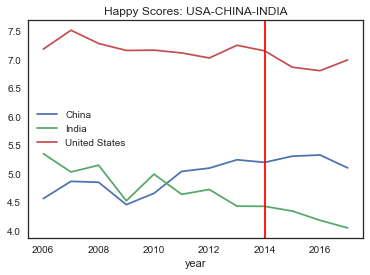

In [256]:
#######################################################################################################@####################
#Here we are going to look at some popular countries and how they compare to one another.
# We will compare: USA, CHINA, and INDIA: each of these were in different happiness score bins from the previous plot
#######################################################################################################@####################
df_uic = df[df['country'].isin(['United States','India','China'])]
df_uic.set_index('year', inplace=True)
df_uic.groupby('country')['happy_score'].plot(legend=True, title='Happy Scores: USA-CHINA-INDIA')
plt.axvline(2014, color='red')

#######################################################################################################@####################
#From this graph we see that all the countries except China have decreased... but why?
# We will split the data into 2 parts @ 2014: data from 2006-2013 and data from 2014-2017
# Goals:
# 1. we will see which features are most significant in the 2014-2017 dataframe and see how countries are different
# 2. we will compare: 2006-2013 USA/CHINA/INDIA to 2014-2017 USA/CHINA/INDIA to see how the significant features for these 3 countries
# have changed over time.
#######################################################################################################@####################

In [262]:
#Creating the 2 data sets: df_14_17 and df_06_13 (contains numerical and categorical data)
#Creating the 2 data sets: df_14_17_num and df_06_13_num (contains only numerical data)

df_clean= df.dropna(thresh=8) #drop all rows that has less than 8 filled in cells
df_14_17 = df_clean[df_clean['year'].isin(['2014','2015','2016','2017'])] #only takes 2015-2017 years
df_06_13 = df_clean[~df_clean['year'].isin(['2014','2015','2016','2017'])] #only takes before 2015 year

#df_14_17_reg = df_14_17.set_index(['country', 'region'])
df_14_17_num = df_14_17.set_index('country')
df_06_13_num = df_06_13.set_index('country')

#df_14_17_reg = df_14_17_reg.iloc[:,1:] #not dropping region
#df_14_17_reg = df_14_17_reg.groupby('country').transform(lambda x: x.fillna(x.mean())) #fill the null values with the mean of the column of that country



df_14_17_num =df_14_17_num.iloc[:,1:12] #drop categorical features
df_14_17_num = df_14_17_num.drop(['life_exp','GDP'],axis=1)
df_06_13_num =df_06_13_num.iloc[:,1:12] #drop categorical features
df_06_13_num = df_06_13_num.drop(['life_exp','GDP'],axis=1)

#df_06_13_num = df_06_13_num.drop('life_exp',axis=1)

df_14_17_num = df_14_17_num.groupby('country').transform(lambda x: x.fillna(x.mean())) #fill the null values with the mean of the column of that country
df_14_17_num.fillna(df_14_17_num.mean(),inplace=True)

df_06_13_num = df_06_13_num.groupby('country').transform(lambda x: x.fillna(x.mean())) #fill the null values with the mean of the column of that country
df_06_13_num.fillna(df_06_13_num.mean(),inplace=True)


df_14_max = df_14_17_num.as_matrix() #needed to change into matrix for clustering
df_06_max = df_06_13_num.as_matrix() #needed to change into matrix for clustering
#df_14_17_reg.reset_index(inplace=True)


# Correlation plotting

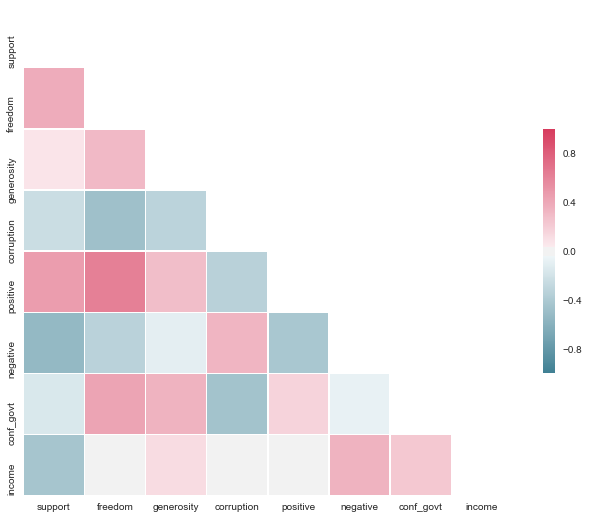

In [263]:
# We want an overall idea of the different features that affect happiness around the world from 2014-2017

from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
a = df_14_17_num.drop('happy_score', axis=1)

# Compute the correlation matrix
corr = a.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 4, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1.0, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [264]:
# We want to do clusters to see which countries are similar but if the country changed drastically over years, then different years
# for each country will be in different clusters. This does not help us... so... 
# So for each country, we are going to average the years together within 2006-2013 and 2014-2016:
# this creates 2 more data frames: df_06_avg and df_14_avg
# we then append these data frames to the original dataframe.
# this will allow us to see how the these specific years are classified into clusters-- these average points are the ones 
# we will be looking at to see where each country is clustered. 


df_14_avg = df_14_17_num.groupby('country').mean()
df_06_avg = df_06_13_num.groupby('country').mean()

df_14_17_num= df_14_17_num.append(df_14_avg)
df_06_13_num= df_06_13_num.append(df_06_avg)



# K MEANS

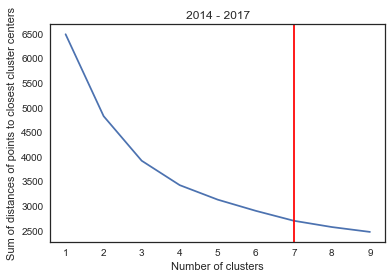

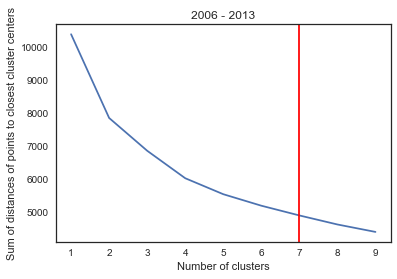

In [265]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.utils import shuffle


df_14_scale = scale(df_14_17_num)

# Create a permutation of the number of datapoints
permutation14 = shuffle(range(len(df_14_17_num)))

df_cluster14 = df_14_scale[permutation14]



sum_of_distances = {}
for num_clusters in range(1,10):
    kmeans = KMeans(n_clusters=num_clusters, random_state=1)
    kmeans.fit(df_cluster14)
    sum_of_distances[num_clusters] = kmeans.inertia_
Series(sum_of_distances).sort_index().plot()
xlabel('Number of clusters')
ylabel('Sum of distances of points to closest cluster centers')
title('2014 - 2017')
plt.axvline(7, color='red')

show()

#####################################################################
#####################################################################

df_06_scale = scale(df_06_13_num)

permutation06 = shuffle(range(len(df_06_13_num)))

df_cluster06 = df_06_scale[permutation06]

sum_of_distances = {}
for num_clusters in range(1,10):
    kmeans = KMeans(n_clusters=num_clusters, random_state=1)
    kmeans.fit(df_cluster06)
    sum_of_distances[num_clusters] = kmeans.inertia_
Series(sum_of_distances).sort_index().plot()
xlabel('Number of clusters')
ylabel('Sum of distances of points to closest cluster centers')
title('2006 - 2013')
plt.axvline(7, color='red')

show()


(3, 5, 1)

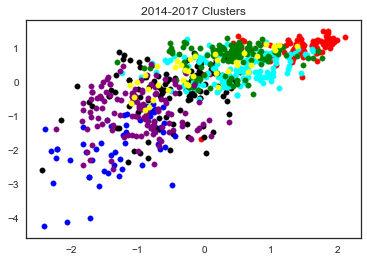

In [266]:
#### K-means for 2014-2017

# import KMeans
from sklearn.cluster import KMeans
# create kmeans object
kmeans = KMeans(init='k-means++',n_clusters=7, random_state=1)
# fit kmeans object to data
kmeans.fit(df_cluster14)
# print location of clusters learned by kmeans object
#print(kmeans.cluster_centers_)
# save new clusters for chart
y_km = kmeans.fit_predict(df_cluster14)
Counter(y_km)

plt.scatter(df_cluster14[y_km ==0,0], df_cluster14[y_km == 0,1], s=30, c='red')
plt.scatter(df_cluster14[y_km ==1,0], df_cluster14[y_km == 1,1], s=30, c='black')
plt.scatter(df_cluster14[y_km ==2,0], df_cluster14[y_km == 2,1], s=30, c='blue')
plt.scatter(df_cluster14[y_km ==3,0], df_cluster14[y_km == 3,1], s=30, c='cyan')
plt.scatter(df_cluster14[y_km ==4,0], df_cluster14[y_km == 4,1], s=30, c='green')
plt.scatter(df_cluster14[y_km==5,0], df_cluster14[y_km == 5,1], s=30, c='purple')
plt.scatter(df_cluster14[y_km ==6,0], df_cluster14[y_km == 6,1], s=30, c='yellow')
#plt.scatter(df_cluster[y_km ==7,0], df_cluster[y_km == 7,1], s=100, c='orange')
#plt.scatter(df_cluster[y_km ==8,0], df_cluster[y_km == 8,1], s=100, c='gray')
#plt.scatter(df_cluster[y_km==9,0], df_cluster[y_km == 9,1], s=100, c='magenta')
title('2014-2017 Clusters')


df_14_17_num['km_cls'] = y_km
km_14_1 = df_14_17_num[df_14_17_num['km_cls'] == 0]
km_14_2 = df_14_17_num[df_14_17_num['km_cls'] == 1]
km_14_3 = df_14_17_num[df_14_17_num['km_cls'] == 2]
km_14_4 = df_14_17_num[df_14_17_num['km_cls'] == 3]
km_14_5 = df_14_17_num[df_14_17_num['km_cls'] == 4]
km_14_6 = df_14_17_num[df_14_17_num['km_cls'] == 5]
km_14_7 = df_14_17_num[df_14_17_num['km_cls'] == 6]


US14 = df_14_17_num.loc['United States'].tail(1)
IN14 = df_14_17_num.loc['India'].tail(1)
CH14 = df_14_17_num.loc['China'].tail(1)
SP14 = df_14_17_num.loc['Spain'].tail(1)


US14 = US14['km_cls'].values[0]
IN14 = IN14['km_cls'].values[0]
CH14 = CH14['km_cls'].values[0]


US14, IN14, CH14
#US14 = 3
#IN14 = 6 
#CH14= 4

(0, 1, 3)

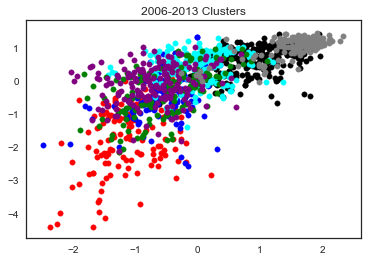

In [267]:
title('2006-2013 Clusters')#### K-means for 2006 - 2013

# import KMeans
from sklearn.cluster import KMeans
# create kmeans object
kmeans = KMeans(init='k-means++',n_clusters=7, random_state=1)
# fit kmeans object to data
kmeans.fit(df_cluster06)
# print location of clusters learned by kmeans object
#print(kmeans.cluster_centers_)
# save new clusters for chart
y_km = kmeans.fit_predict(df_cluster06)
Counter(y_km)

plt.scatter(df_cluster06[y_km ==0,0], df_cluster06[y_km == 0,1], s=30, c='red')
plt.scatter(df_cluster06[y_km ==1,0], df_cluster06[y_km == 1,1], s=30, c='black')
plt.scatter(df_cluster06[y_km ==2,0], df_cluster06[y_km == 2,1], s=30, c='blue')
plt.scatter(df_cluster06[y_km ==3,0], df_cluster06[y_km == 3,1], s=30, c='cyan')
plt.scatter(df_cluster06[y_km ==4,0], df_cluster06[y_km == 4,1], s=30, c='green')
plt.scatter(df_cluster06[y_km==5,0], df_cluster06[y_km == 5,1], s=30, c='purple')
plt.scatter(df_cluster06[y_km ==6,0], df_cluster06[y_km == 6,1], s=30, c='gray')
title('2006-2013 Clusters')

df_06_13_num['km_cls'] = y_km
km_06_1 = df_06_13_num[df_06_13_num['km_cls'] == 0]
km_06_2 = df_06_13_num[df_06_13_num['km_cls'] == 1]
km_06_3 = df_06_13_num[df_06_13_num['km_cls'] == 2]
km_06_4 = df_06_13_num[df_06_13_num['km_cls'] == 3]
km_06_5 = df_06_13_num[df_06_13_num['km_cls'] == 4]
km_06_6 = df_06_13_num[df_06_13_num['km_cls'] == 5]
km_06_7 = df_06_13_num[df_06_13_num['km_cls'] == 6]


US06 = df_06_13_num.loc['United States'].tail(1)
IN06 = df_06_13_num.loc['India'].tail(1)
CH06 = df_06_13_num.loc['China'].tail(1)
SP06 = df_06_13_num.loc['Spain'].tail(1)


US06 = US06['km_cls'].values[0]
IN06 = IN06['km_cls'].values[0]
CH06 = CH06['km_cls'].values[0]


US06, IN06, CH06
#US06=5
#IN06=5
#CH06=3


# Correlation for 2014-2017

# 2014-2017 USA

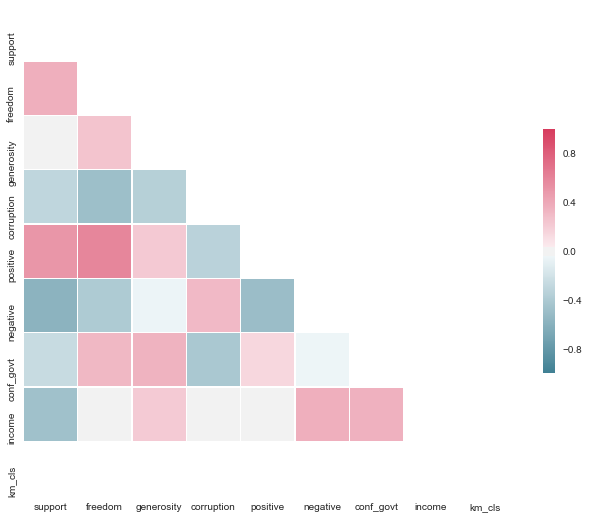

In [269]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
a = km_14_5.drop('happy_score', axis=1)

# Compute the correlation matrix
corr = a.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 4, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1.0, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
#km_14_5
#km_14_5[km_14_5.columns[0]]

In [301]:
from sklearn import preprocessing
import warnings
b = km_14_2
warnings.filterwarnings("ignore")
target = b[b.columns[0]]
data = b[b.columns[1:9]]
#data = b[['GDP', 'life_exp','freedom', 'corruption','conf_govt']]
#data2 = b[['support', 'generosity', 'positive','negative','income']]
#data= preprocessing.scale(data)
#data
#['GDP', 'life_exp','freedom', 'corruption','conf_govt']

array([ True,  True, False, False, False, False, False, False])

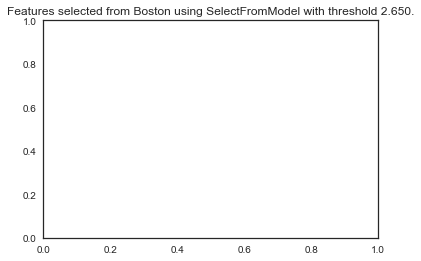

In [303]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

# Load the boston dataset.
X, y = data, target

# We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
clf = LassoCV(normalize = True)

# Set a minimum threshold of 0.25
sfm = SelectFromModel(clf, threshold=0.25)
sfm.fit(X, y)
n_features = sfm.transform(X).shape[1]

# Reset the threshold till the number of features equals two.
# Note that the attribute can be set directly instead of repeatedly
# fitting the metatransformer.
while n_features > 2:
    sfm.threshold += 0.2
    X_transform = sfm.transform(X)
    n_features = X_transform.shape[1]

# Plot the selected two features from X.
plt.title(
    "Features selected from Boston using SelectFromModel with "
    "threshold %0.3f." % sfm.threshold)
#feature1 = X_transform[:, 0]
#feature2 = X_transform[:, 1]
#plt.plot(feature1, feature2, 'r.')
#plt.xlabel("Feature number 1")
#plt.ylabel("Feature number 2")
#plt.ylim([np.min(feature2), np.max(feature2)])
#plt.show()
sfm.get_support()

#km_14_4

In [275]:
# create formula for regression on each of the clusters
formula = df_14_17_num.columns.get_values()
formula = formula.tolist()
formula.remove('happy_score')
formula.remove('km_cls')
a = 'GDP + life_exp + freedom + corruption + conf_govt'

f = 'happy_score ~ ' +"+".join(formula)
#f = 'happy_score ~ ' + " + ".join(formula)+"+ life_exp*GDP"
#f = 'happy_score ~ ' + " + ".join(formula) "+ support*positive + corruption*conf_govt - positive -negative - income - support - generosity"
#f = 'happy_score ~ ' + " + ".join(formula) + " + GDP*income "


#km_14_5 = scale(km_14_5)
y, X = dmatrices(f, km_14_1, return_type='dataframe')
result = sm.OLS(y, X).fit()      # Fit model (find the intercept and slopes)
print result.summary()

#US14
#km_14_3
#interaction variable: conf_govt*GDP
#sig vars: life_exp, freedom

                            OLS Regression Results                            
Dep. Variable:            happy_score   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     28.19
Date:                Sun, 12 Aug 2018   Prob (F-statistic):           7.01e-21
Time:                        17:19:08   Log-Likelihood:                -73.127
No. Observations:                  94   AIC:                             164.3
Df Residuals:                      85   BIC:                             187.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7170      1.061      1.618      0.1

# 2014 - 2017 India

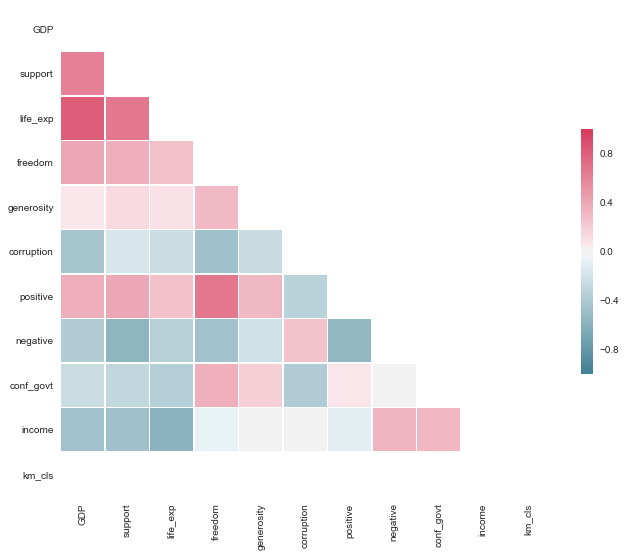

In [832]:
a = km_14_6.drop('happy_score', axis=1)

# Compute the correlation matrix
corr = a.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1.0, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [833]:
formula = df_14_17_num.columns.get_values()
formula = formula.tolist()
formula.remove('happy_score')
formula.remove('km_cls')
a = 'GDP + life_exp + freedom + corruption + conf_govt'

#f = 'happy_score ~ ' +"+".join(formula)
f = 'happy_score ~ ' + " + ".join(formula)+"+ life_exp*GDP"
#f = 'happy_score ~ ' + " + ".join(formula) "+ support*positive + corruption*conf_govt - positive -negative - income - support - generosity"
#f = 'happy_score ~ ' + " + ".join(formula) + " + GDP*income "

y, X = dmatrices(f, km_14_6, return_type='dataframe')
result = sm.OLS(y, X).fit()      # Fit model (find the intercept and slopes)
print result.summary()

#IN14
#km_14_6
#interaction variable: life_exp*GDP
#sig vars: support, positive

                            OLS Regression Results                            
Dep. Variable:            happy_score   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     45.14
Date:                Sat, 11 Aug 2018   Prob (F-statistic):           8.48e-29
Time:                        23:06:50   Log-Likelihood:                -45.860
No. Observations:                  88   AIC:                             115.7
Df Residuals:                      76   BIC:                             145.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.7125      3.141      1.182   

# 2014-2017 China

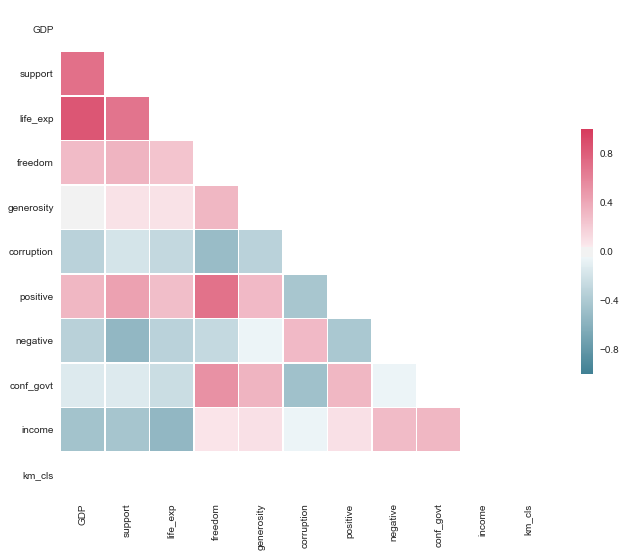

In [834]:
a = km_14_4.drop('happy_score', axis=1)

# Compute the correlation matrix
corr = a.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1.0, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [848]:
formula = df_14_17_num.columns.get_values()
formula = formula.tolist()
formula.remove('happy_score')
formula.remove('km_cls')
a = 'GDP + life_exp + freedom + corruption + conf_govt'

#f = 'happy_score ~ ' +"+".join(formula)
f = 'happy_score ~ ' + " + ".join(formula)+"+ life_exp*support"
#f = 'happy_score ~ ' + " + ".join(formula) "+ support*positive + corruption*conf_govt - positive -negative - income - support - generosity"
#f = 'happy_score ~ ' + " + ".join(formula) + " + GDP*income "

y, X = dmatrices(f, km_14_4, return_type='dataframe')
result = sm.OLS(y, X).fit()      # Fit model (find the intercept and slopes)
print result.summary()

#CH14
#km_14_4
#interaction variable: life_exp*support
#sig vars: corruption, positive

                            OLS Regression Results                            
Dep. Variable:            happy_score   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     69.01
Date:                Sun, 12 Aug 2018   Prob (F-statistic):           5.86e-54
Time:                        11:27:41   Log-Likelihood:                -110.60
No. Observations:                 167   AIC:                             245.2
Df Residuals:                     155   BIC:                             282.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.8538      2.274  

# 2006-2013 USA and India

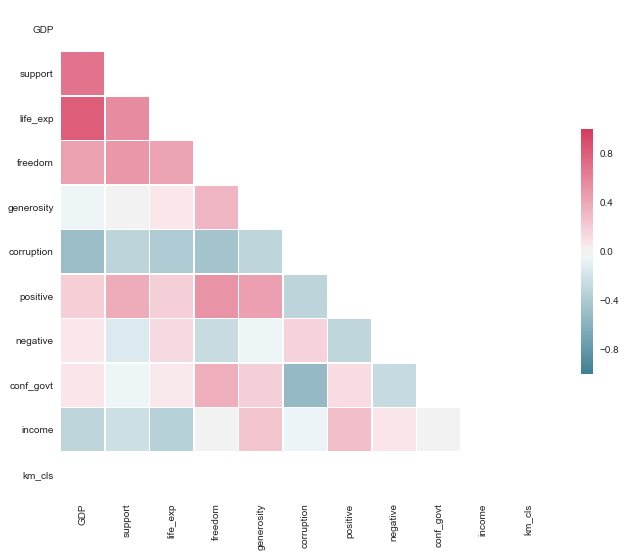

In [836]:
a = km_06_2.drop('happy_score', axis=1)

# Compute the correlation matrix
corr = a.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1.0, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [763]:
formula = df_06_13_num.columns.get_values()
formula = formula.tolist()
formula.remove('happy_score')
formula.remove('km_cls')
a = 'GDP + life_exp + freedom + corruption + conf_govt'

#f = 'happy_score ~ ' +"+".join(formula)
f = 'happy_score ~ ' + " + ".join(formula)+"+ positive*freedom"
#f = 'happy_score ~ ' + " + ".join(formula) "+ support*positive + corruption*conf_govt - positive -negative - income - support - generosity"
#f = 'happy_score ~ ' + " + ".join(formula) + " + GDP*income "

y, X = dmatrices(f, km_06_2, return_type='dataframe')
result = sm.OLS(y, X).fit()      # Fit model (find the intercept and slopes)
print result.summary()

#US06 and IN06
#km_06_2
#interaction variable: positive*freedom
#sig vars: negative, GDP

                            OLS Regression Results                            
Dep. Variable:            happy_score   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     57.44
Date:                Sat, 11 Aug 2018   Prob (F-statistic):           1.91e-39
Time:                        22:21:03   Log-Likelihood:                -42.900
No. Observations:                 108   AIC:                             115.8
Df Residuals:                      93   BIC:                             156.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

# 2006-2013 China

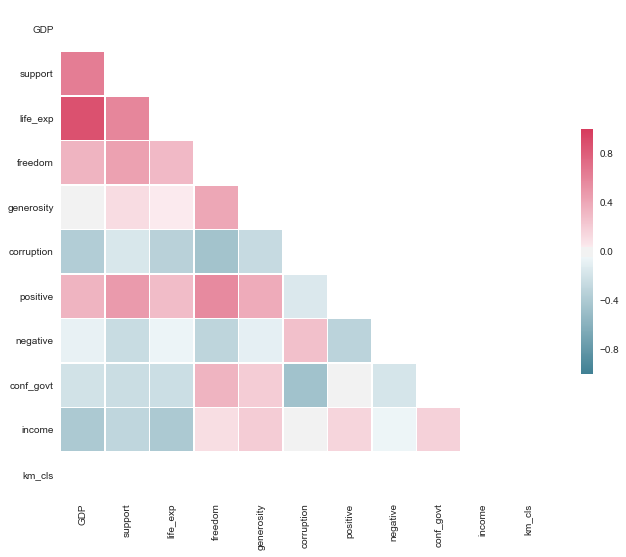

In [764]:
a = km_06_1.drop('happy_score', axis=1)

# Compute the correlation matrix
corr = a.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1.0, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [778]:
formula = df_06_13_num.columns.get_values()
formula = formula.tolist()
formula.remove('happy_score')
formula.remove('km_cls')
a = 'GDP + life_exp + freedom + corruption + conf_govt'

#f = 'happy_score ~ ' +"+".join(formula)
f = 'happy_score ~ ' + " + ".join(formula)+"+ GDP*life_exp"
#f = 'happy_score ~ ' + " + ".join(formula) "+ support*positive + corruption*conf_govt - positive -negative - income - support - generosity"
#f = 'happy_score ~ ' + " + ".join(formula) + " + GDP*income "

y, X = dmatrices(f, km_06_1, return_type='dataframe')
result = sm.OLS(y, X).fit()      # Fit model (find the intercept and slopes)
print result.summary()

#US06 and IN06
#km_06_2
#interaction variable: life_exp, GDP
#sig vars: income, support, positive

                            OLS Regression Results                            
Dep. Variable:            happy_score   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     53.31
Date:                Sat, 11 Aug 2018   Prob (F-statistic):           3.75e-49
Time:                        22:27:25   Log-Likelihood:                -135.24
No. Observations:                 181   AIC:                             294.5
Df Residuals:                     169   BIC:                             332.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.1379      2.420      2.536   

### Linear regression of entire model

In [779]:
formula = df_14_17_num.columns.get_values()
formula = formula.tolist()
formula.remove('happy_score')
f_wo_country = formula
#f_wo_country.remove('country')
f_wo_country.remove('km_cls')

f = " + ".join(formula)
f_wo_country = " + ".join(formula)

f = 'happy_score ~ ' + f

f_wo_country = 'happy_score ~ ' + f_wo_country

In [780]:
#df.groupby('Region indicator')['Life Ladder'].mean().plot(kind='bar')



y, X = dmatrices(f_wo_country, df_14_17_num, return_type='dataframe')
result = sm.OLS(y, X).fit()      # Fit model (find the intercept and slopes)
print result.summary()



                            OLS Regression Results                            
Dep. Variable:            happy_score   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     295.1
Date:                Sat, 11 Aug 2018   Prob (F-statistic):          3.70e-245
Time:                        22:28:24   Log-Likelihood:                -519.32
No. Observations:                 721   AIC:                             1061.
Df Residuals:                     710   BIC:                             1111.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0350      0.390     -2.653      0.0

# PCA - we can reduce it down to 6 variables: there is a good amnt of correlation

[ 37.91  58.65  68.9   77.8   83.6   88.48  91.79  94.58  97.03  98.75
 100.  ]
[ 1.36787535 -0.85246358 -0.76761118  0.31754368  0.81525037 -1.21055605]


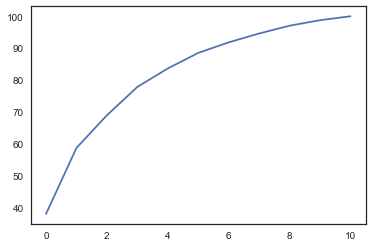

In [420]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
%matplotlib inline


#Scaling the values
X = scale(df_06_13_num)

pca = PCA(n_components=11)

pca.fit(X)

#The amount of variance that each PC explains
var= pca.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

print var1

plt.plot(var1)

#Looking at above plot I'm taking 30 variables
pca = PCA(n_components=6)
pca.fit(X)
X1=pca.fit_transform(X)

print X1[6]



[38.99 58.15 66.45 73.44 80.23 86.24 90.44 93.24 95.69 97.69 98.96]
[ 0.88580903 -0.91937268  0.9672267   0.39378469  0.31063532  0.19705171]


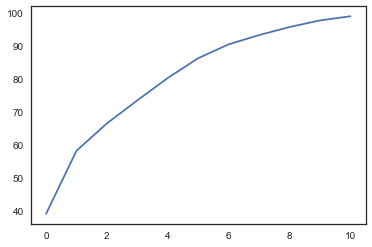

In [202]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
%matplotlib inline


#Scaling the values
X = scale(df_14_17_num)

pca = PCA(n_components=11)

pca.fit(X)

#The amount of variance that each PC explains
var= pca.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

print var1

plt.plot(var1)

#Looking at above plot I'm taking 30 variables
pca = PCA(n_components=6)
pca.fit(X)
X1=pca.fit_transform(X)

print X1[6]



# Cluster Map for 2014-2017


In [245]:


import plotly
plotly.tools.set_credentials_file(username='phatpoosh', api_key='nJsLQ2InTkHvSgd17qo1')
df2 = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')
df1_test = df_14_avg.merge(df_14_17_num[['happy_score','km_cls']],
                        left_on = ['country','happy_score'],
                        right_on=['country','happy_score'])
                          

df_test = df1_test.merge(df2[['COUNTRY','CODE']],
                  how='left',
                 left_on = 'country',
                 right_on='COUNTRY')
df_test

,level_0,index,country,happy_score,GDP,support,life_exp,freedom,generosity,corruption,positive,negative,conf_govt,income,km_cls,COUNTRY,CODE
0,0,0,Afghanistan,3.498909,7.468086,0.526029,51.855027,0.461755,0.040999,0.874880,0.536636,0.358449,0.313943,0.429030,2,Afghanistan,AFG
1,1,1,Albania,4.642766,9.323155,0.635263,68.781881,0.729482,-0.043963,0.886176,0.679441,0.335140,0.466103,0.416718,6,Albania,ALB
2,2,2,Algeria,5.648221,9.530207,0.791177,65.446287,0.436670,-0.194670,0.699774,0.642798,0.280896,0.484954,0.535888,0,Algeria,DZA
3,3,3,Angola,3.794838,8.741957,0.754615,52.460709,0.374542,-0.157882,0.834076,0.578517,0.367864,0.572346,0.440699,6,Angola,AGO
4,3,3,Angola,3.794838,8.741957,0.754615,52.460709,0.374542,-0.157882,0.834076,0.578517,0.367864,0.572346,0.440699,2,Angola,AGO
5,4,4,Argentina,6.458699,9.841867,0.908470,67.328417,0.826487,-0.179273,0.849269,0.841749,0.286658,0.378031,0.345649,3,Argentina,ARG
6,5,5,Armenia,4.353653,9.010096,0.717114,64.881254,0.570549,-0.172148,0.901989,0.598429,0.429077,0.204364,0.406694,1,Armenia,ARM
7,6,6,Australia,7.276182,10.694845,0.941988,72.583839,0.919417,0.286366,0.402117,0.784052,0.229097,0.462343,0.454225,5,Australia,AUS
8,7,7,Austria,7.092062,10.703584,0.914892,71.894714,0.890969,0.098973,0.541589,0.770357,0.178078,0.432758,0.319843,1,Austria,AUT
9,8,8,Azerbaijan,5.213620,9.695266,0.787362,62.917237,0.735167,-0.232372,0.632177,0.598537,0.203883,0.766833,0.286071,5,Azerbaijan,AZE


In [297]:
import plotly.plotly as py
import pandas as pd


data = [ dict(
        type = 'choropleth',
        locations = df_test['CODE'],
        z = df_test['km_cls'],
        text = df_test['country'],
        colorscale = [[1,"rgb(255, 0, 0)"],[2,"rgb(255, 128, 0)"],[3,"rgb(255, 255, 0)"],\
            [4,"rgb(0, 255, 0)"],[5,"rgb(0, 0, 255)"],[6,"rgb(0, 0, 255)"],[7,"rgb(255, 0, 128)"]],
        autocolorscale = False,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Cluster Bin'),
      ) ]

layout = dict(
    title = 'Cluster Map: 2014-2017',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )



# Cluster Map for 2006-2013

In [244]:


import plotly
plotly.tools.set_credentials_file(username='phatpoosh', api_key='nJsLQ2InTkHvSgd17qo1')
df2 = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')
df2_test = df_06_avg.merge(df_06_13_num[['happy_score','km_cls']],
                        left_on = ['country','happy_score'],
                        right_on=['country','happy_score'])
                          

df3_test = df2_test.merge(df2[['COUNTRY','CODE']],
                  how='left',
                 left_on = 'country',
                 right_on='COUNTRY')

df3_test

,happy_score,GDP,support,life_exp,freedom,generosity,corruption,positive,negative,conf_govt,income,km_cls,COUNTRY,CODE
0,4.011751,7.387438,0.511223,50.160433,0.600322,0.170048,0.794737,0.610364,0.263172,0.458108,0.350979,6,Afghanistan,AFG
1,5.219475,9.196328,0.781830,67.524100,0.557271,-0.145724,0.842035,0.618086,0.282000,0.334556,0.554021,4,Albania,ALB
2,5.461786,9.473250,0.824816,64.522636,0.569640,-0.212758,0.648712,0.577113,0.242306,0.486194,0.446774,4,Algeria,DZA
3,4.628786,8.704595,0.732426,51.486165,0.483095,-0.051293,0.877999,0.624946,0.345609,0.339070,0.588065,2,Angola,AGO
4,6.379846,9.818143,0.904885,66.482100,0.716439,-0.142179,0.841423,0.840622,0.266452,0.411865,0.352514,3,Argentina,ARG
5,4.403198,8.853971,0.699521,63.807887,0.494863,-0.202705,0.872815,0.516132,0.434585,0.350944,0.415182,5,Armenia,ARM
6,7.327894,10.629435,0.953451,71.783080,0.926651,0.298740,0.411642,0.824995,0.211247,0.531500,0.407848,5,Australia,AUS
7,7.329308,10.691002,0.937374,70.700336,0.916204,0.181862,0.633687,0.811504,0.161219,0.406887,0.349233,0,Austria,AUT
8,4.747247,9.589591,0.746457,61.769542,0.587766,-0.159763,0.778680,0.548646,0.257416,0.740722,0.331495,2,Azerbaijan,AZE
9,5.635653,10.621559,0.896851,65.398827,0.823767,-0.019195,0.553173,0.669848,0.409061,0.486194,0.353978,4,Bahrain,BHR


In [250]:
import plotly.plotly as py
import pandas as pd


data = [ dict(
        type = 'choropleth',
        locations = df3_test['CODE'],
        z = df3_test['km_cls'],
        text = df3_test['COUNTRY'],
        colorscale = [[1,"rgb(255, 0, 0)"],[2,"rgb(255, 128, 0)"],[3,"rgb(255, 255, 0)"],\
            [4,"rgb(0, 255, 0)"],[5,"rgb(0, 0, 255)"],[6,"rgb(0, 0, 255)"],[7,"rgb(255, 0, 128)"]],
        autocolorscale = False,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Cluster Bin'),
      ) ]

layout = dict(
    title = 'Cluster Map: 2006-2013',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

